In [1]:
import numpy as np 
import pandas as pd 
import os 
from PIL import Image 
from skimage.io import imread
import torch 
from torch.utils.data.dataset import Dataset
import torchvision as tv 

class ADNIDataset(Dataset): 
    def __init__(self, csv_path, base_path='/home/aay993/bias_corrected_registered_slices/', crop_type=None, crop_size=(192, 192), downsample: int = None):
        super().__init__()
        self.csv_path = csv_path 
        self.base_path = base_path

        self.crop_type = crop_type
        self.crop_size = crop_size

        self.downsample = downsample

        csv = pd.read_csv(csv_path)

        #get the length of the dataset for __len__
        self.num_items = len(csv)
    
        self.metrics = {col: torch.as_tensor(csv[col]).float() if col != 'PTID' else csv[col] for col in csv.columns} 
        

    def __len__(self):
        return self.num_items
    
    def __getitem__(self, index): 
        item = {col: values[index] for col, values in self.metrics.items()}

        img_path = os.path.join(self.base_path, f'slice_{int(item["slice_number"])}_bias_corrected_registered_ADNI_{item["PTID"]}.png')
        img = torch.tensor(imread(img_path, as_gray=True), dtype=torch.float32)
        
        # You can also load the images directly using PIL but then you can't clip borders as easily
        # img = Image.open(img_path).convert('L')

        # clip image border from PNG files 
        border_clip = 8 
        img = img[border_clip:-border_clip, border_clip:-border_clip]
        
        transform_list = []
        transform_list += [tv.transforms.ToPILImage()]
        if self.crop_type is not None:
            if self.crop_type == 'center':
                transform_list += [tv.transforms.CenterCrop(self.crop_size)]
            elif self.crop_type == 'random':
                transform_list += [tv.transforms.RandomCrop(self.crop_size)]
            else:
                raise ValueError('unknwon crop type: {}'.format(self.crop_type))

        if self.downsample is not None and self.downsample > 1:
            transform_list += [tv.transforms.Resize(tuple(np.array(self.crop_size) // self.downsample))]

        transform_list += [tv.transforms.ToTensor()]

        img = tv.transforms.Compose(transform_list)(img)

        item['x'] = img # the 'x' here used to be 'image'

        return item 

In [62]:
from torch.utils.data import DataLoader
downsample = 3 
split_dir = '/home/aay993/'
data_dir = '/home/aay993/bias_corrected_registered_slices/'
adni_val = ADNIDataset(f'{split_dir}/full_imputed_clinical_covariates.csv', base_path=data_dir, crop_type='center', downsample=downsample)
test_batch_size = 20
required_data = {'x', 'sex', 'age', 'ventricle_volume', 'brain_volume', 'tau', 'av45', 
        'moca', 'education', 'APOE4', 'slice_number'}
torch_device = 'cuda'
training = True 

def val_dataloader():
    val_loader = DataLoader(adni_val, batch_size=test_batch_size, shuffle=False)
    return val_loader

def get_batch(loader):
        batch = next(iter(loader))
        batch = {k: v.to(torch_device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()} #This might be more general-purpose 
        # if self.trainer.on_gpu:
        # batch = self.trainer.accelerator_backend.to_device(batch, self.torch_device)
        return batch

def prep_batch(batch):
        x = 255. * batch['x'].float()  # multiply by 255 b/c preprocess tfms
        out = dict(x=x)
        for k in required_data:
            if k in batch and k != 'x':
                out[k] = batch[k].unsqueeze(1).float()

        # if training: 
        #     out['x'] += (torch.rand_like(out['x']) - 0.5)
        
        return out 

val_loader = val_dataloader()

obs_batch = prep_batch(get_batch(val_loader))


In [63]:
print(obs_batch['x'].shape)

torch.Size([20, 1, 64, 64])


In [64]:
obs_batch = {k: v[:8] for k, v in obs_batch.items()}

In [65]:
print(obs_batch['x'].shape)

torch.Size([8, 1, 64, 64])


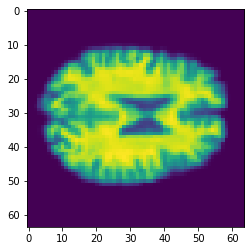

In [66]:
import matplotlib.pyplot as plt 

plt.imshow(obs_batch['x'][6].cpu().numpy().squeeze())

In [67]:
import torchvision.utils
def log_img_grid(tag, imgs, normalize=False, save_img=True, **kwargs):
    imgs = imgs.clamp_(min=0., max=255.)
    if save_img:
        p = os.path.join(f'{tag}.png')
        torchvision.utils.save_image(imgs, p)

log_img_grid('testing', obs_batch['x'])

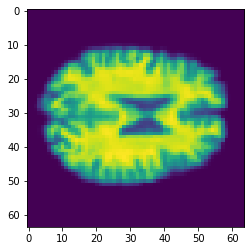

In [68]:
plt.imshow(obs_batch['x'][6].cpu().numpy().squeeze())